<a href="https://colab.research.google.com/github/AndrewKruszka/NeuralMachineLearning/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

Based on [[this notebook]](https://github.com/smartgeometry-ucl/dl4g/blob/master/gan.ipynb).

In [81]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

Parameter Settings
-------------------


In [82]:
latent_dims = 100  # Increased for richer latent space
num_epochs = 20    # More epochs for better training
batch_size = 128
learning_rate = 2e-4
use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [83]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([1, 28, 28])


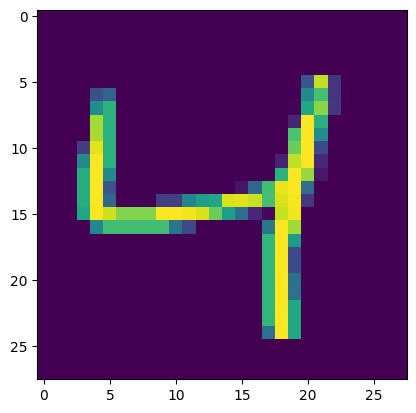

In [84]:
plt.imshow(train_dataset[2][0][0])
print(train_dataset[2][0].shape)

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [85]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        # Starting with 1x1 input from latent vector
        self.main = nn.Sequential(
            # Input is latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),    # 32x32
            nn.Tanh()
        )

    def forward(self, input):
        # Ensure input is properly shaped as [batch_size, latent_dim, 1, 1]
        if input.dim() == 2:
            input = input.unsqueeze(-1).unsqueeze(-1)
        elif input.dim() == 4 and (input.size(2) != 1 or input.size(3) != 1):
            input = input.view(input.size(0), input.size(1), 1, 1)

        x = self.main(input)
        # Center crop to 28x28
        x = x[:, :, 2:30, 2:30]
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input is 1 x 28 x 28
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 3x3
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 3, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)  # Ensure output is [batch_size, 1]

generator = Generator(latent_dim=latent_dims).to(device)
discriminator = Discriminator().to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 3444480 and discriminator: 659456


Train GAN
--------


In [86]:
# Updated training parameters
latent_dim = 100
num_epochs = 20
batch_size = 128
learning_rate = 2e-4

# Data loading - using full dataset
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the models and move to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
print('Training...')
for epoch in range(num_epochs):
    gen_losses = []
    disc_losses = []

    for i, (real_images, _) in enumerate(train_dataloader):
        batch_size = real_images.size(0)

        # Move batch to device
        real_images = real_images.to(device)

        # Create labels with smoothing
        real_labels = torch.full((batch_size, 1), 0.9, device=device)
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)

        # Add noise to real images (regularization)
        real_images_noisy = real_images + 0.1 * torch.randn_like(real_images)

        # ===== Train Discriminator =====
        disc_optimizer.zero_grad()

        # Train with real images
        real_output = discriminator(real_images_noisy)
        d_loss_real = criterion(real_output, real_labels)

        # Train with fake images
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Combined loss and optimize
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        disc_optimizer.step()

        # ===== Train Generator =====
        gen_optimizer.zero_grad()

        # Generate new fake images
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images)

        # Loss and optimize - we want discriminator to think these are real
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        gen_optimizer.step()

        # Record losses
        gen_losses.append(g_loss.item())
        disc_losses.append(d_loss.item())

        # Print progress
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Epoch summary
    avg_gen_loss = sum(gen_losses) / len(gen_losses)
    avg_disc_loss = sum(disc_losses) / len(disc_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Generator Loss: {avg_gen_loss:.4f}, '
          f'Discriminator Loss: {avg_disc_loss:.4f}')

    # Save sample images every few epochs
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            sample_z = torch.randn(16, latent_dim, 1, 1, device=device)
            sample_images = generator(sample_z)
            sample_images = sample_images.cpu().detach()
            # Save or display images here

Training...
Epoch [1/20], Step [100/469], d_loss: 0.6529, g_loss: 2.1142
Epoch [1/20], Step [200/469], d_loss: 0.6515, g_loss: 2.1102
Epoch [1/20], Step [300/469], d_loss: 0.6559, g_loss: 1.9619
Epoch [1/20], Step [400/469], d_loss: 0.6514, g_loss: 2.1619
Epoch [1/20], Generator Loss: 2.1513, Discriminator Loss: 0.6630
Epoch [2/20], Step [100/469], d_loss: 0.6526, g_loss: 1.9405
Epoch [2/20], Step [200/469], d_loss: 0.6514, g_loss: 2.1872
Epoch [2/20], Step [300/469], d_loss: 0.6506, g_loss: 2.0774
Epoch [2/20], Step [400/469], d_loss: 0.6506, g_loss: 2.1242
Epoch [2/20], Generator Loss: 2.0931, Discriminator Loss: 0.6514
Epoch [3/20], Step [100/469], d_loss: 0.6555, g_loss: 1.8965
Epoch [3/20], Step [200/469], d_loss: 0.6511, g_loss: 1.9577
Epoch [3/20], Step [300/469], d_loss: 0.6505, g_loss: 2.0346
Epoch [3/20], Step [400/469], d_loss: 0.6504, g_loss: 2.1245
Epoch [3/20], Generator Loss: 2.0927, Discriminator Loss: 0.6511
Epoch [4/20], Step [100/469], d_loss: 0.6503, g_loss: 2.1004


Plot Training Curves
--------------------

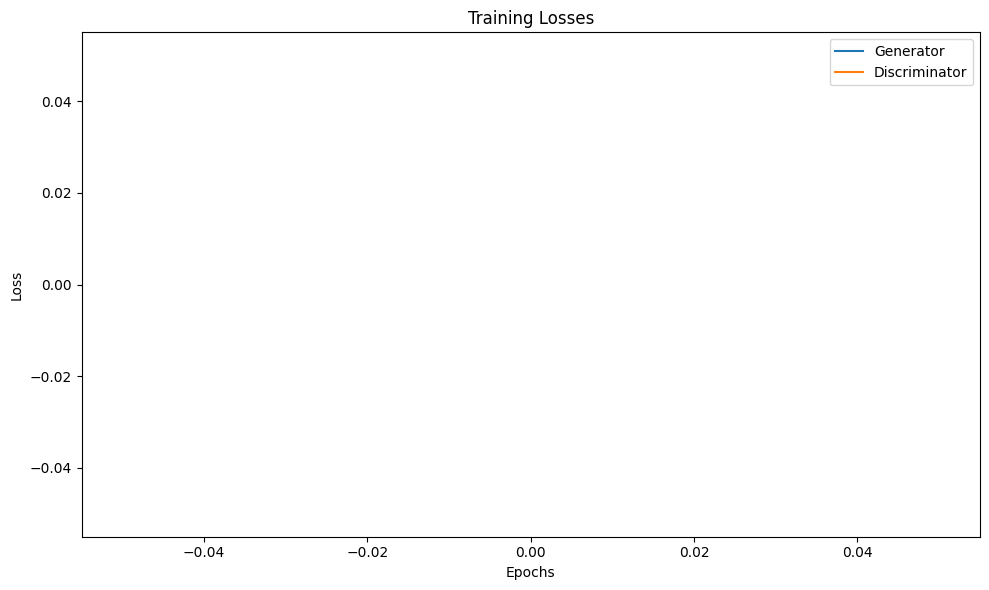

In [95]:
# Plot Training Curves
import matplotlib.pyplot as plt

# Create figure with proper size
plt.figure(figsize=(10, 6))

# Plot generator and discriminator losses
epochs = range(1, len(gen_losses_per_epoch) + 1)
plt.plot(epochs, gen_losses_per_epoch, label='Generator')
plt.plot(epochs, disc_losses_per_epoch, label='Discriminator')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

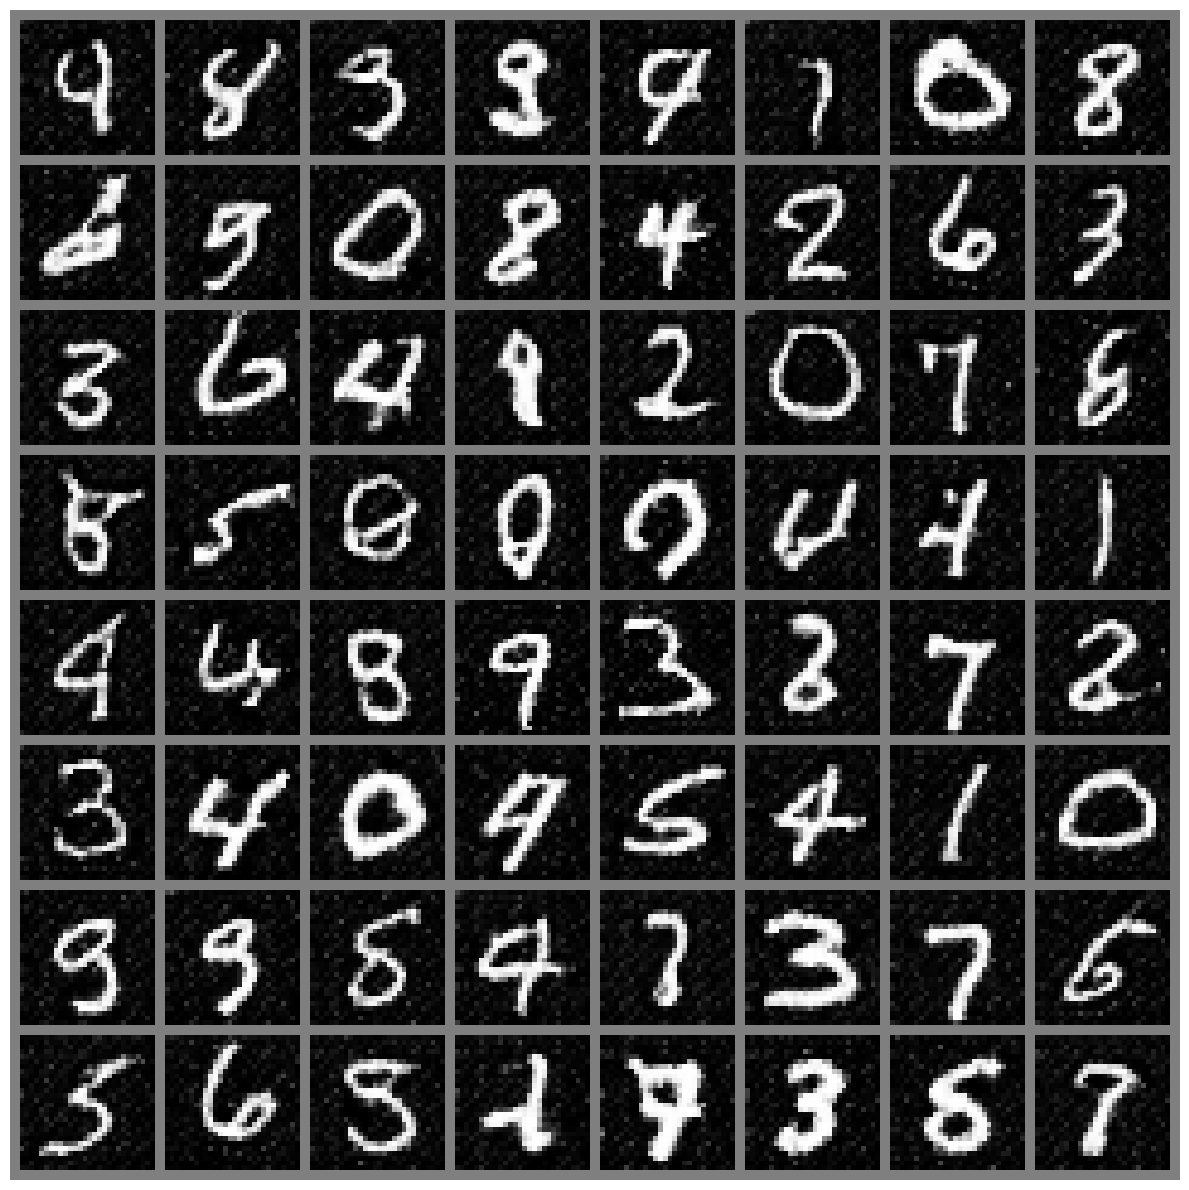

In [91]:
# Sample Latent Vector from Prior (GAN as Generator)
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils

# Set the generator to evaluation mode
generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)  # Convert from [-1, 1] to [0, 1]
    x = x.clamp(0, 1)
    return x

def show_grid(img_tensor):
    # Convert to numpy and transpose for plotting
    img_grid = torchvision.utils.make_grid(img_tensor, nrow=8)
    img_grid = to_img(img_grid)
    npimg = img_grid.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate a batch of images
with torch.no_grad():
    # Sample latent vectors from the standard normal distribution
    sample_size = 64
    latent = torch.randn(sample_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)
    fake_images = fake_images.cpu()

    # Display the generated images
    show_grid(fake_images)

Interpolate in Latent Space
----------------------------

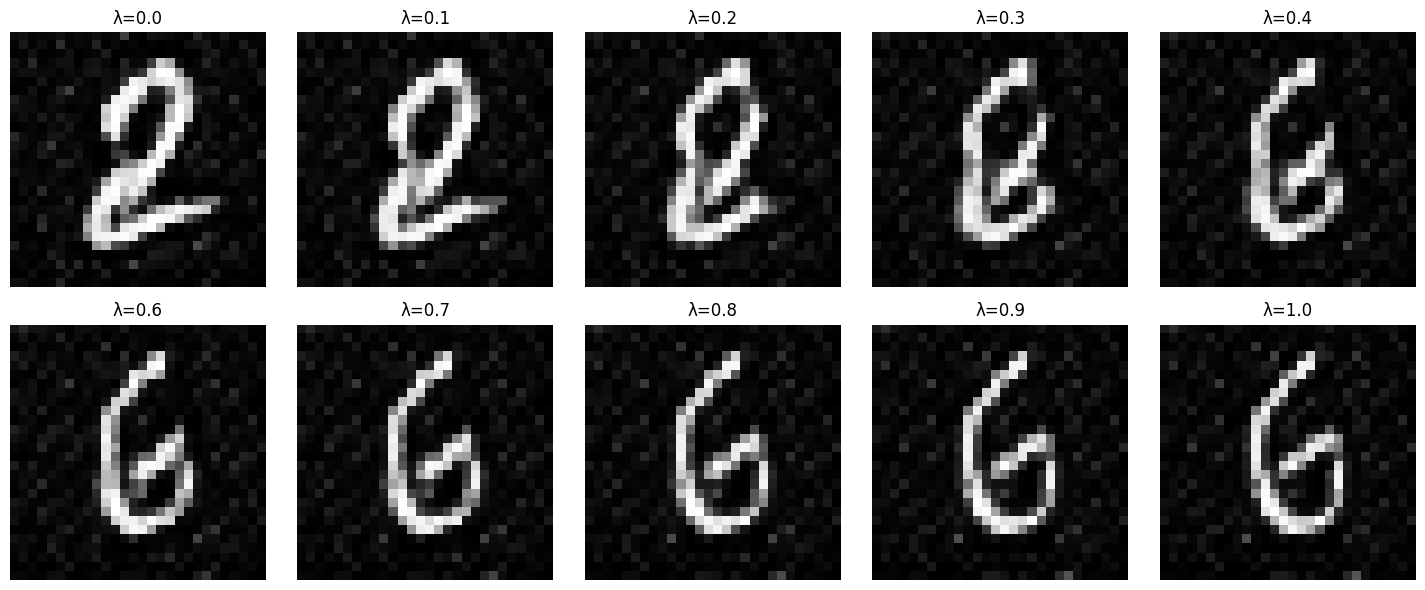

In [92]:
# Interpolate in Latent Space
import numpy as np
import matplotlib.pyplot as plt

# Set generator to evaluation mode
generator.eval()

def interpolate(lambda_val, model, latent_1, latent_2):
    with torch.no_grad():
        # Interpolate between the two latent vectors
        inter_latent = lambda_val * latent_1 + (1 - lambda_val) * latent_2

        # Generate image from interpolated latent vector
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# Sample two random latent vectors
latent_1 = torch.randn(1, latent_dim, 1, 1, device=device)
latent_2 = torch.randn(1, latent_dim, 1, 1, device=device)

# Create interpolation steps
num_steps = 10
lambda_range = np.linspace(0, 1, num_steps)

# Generate and display interpolated images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()

for i, l in enumerate(lambda_range):
    inter_image = interpolate(float(l), generator, latent_1, latent_2)

    # Convert to numpy for display
    inter_image = to_img(inter_image)
    image = inter_image.numpy()

    # Display in the grid
    axs[i].imshow(image[0, 0, :, :], cmap='gray')
    axs[i].set_title(f'λ={l:.1f}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()